In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
infos = pd.read_csv('./data/infos.csv', sep = '|')

In [10]:
items = pd.read_csv('./data/items.csv', sep = '|')

In [11]:
orders = pd.read_csv('./data/orders.csv', sep = '|', parse_dates=['time'])

## - Creating the structure

In [12]:
df = orders.copy()

In [13]:
df['weekpair'] = (df.time.dt.dayofyear + 1) // 14 - 13

In [14]:
df.head()

,time,transactID,itemID,order,salesPrice,weekpair
0,2018-01-01 00:01:56,2278968,450,1,17.42,-13
1,2018-01-01 00:01:56,2278968,83,1,5.19,-13
2,2018-01-01 00:07:11,2255797,7851,2,20.47,-13
3,2018-01-01 00:09:24,2278968,450,1,17.42,-13
4,2018-01-01 00:09:24,2278968,83,1,5.19,-13


In [15]:
npairs = df.weekpair.nunique()

In [16]:
n_items = items['itemID'].nunique()
print('total number of items:', n_items)
print('expected number of instances:', n_items * npairs)

total number of items: 10463
expected number of instances: 136019


In [17]:
mi = pd.MultiIndex.from_product([range(-npairs, 0), items['itemID']], names=['weekpair', 'itemID'])
data_temp = pd.DataFrame(index = mi)

In [18]:
data_temp = data_temp.join(df.groupby(['weekpair', 'itemID'])[['order']].sum(), how = 'left')

In [19]:
data_temp.fillna(0, inplace = True)

In [20]:
data_temp.groupby('itemID').count().min()

order    13
dtype: int64

In [21]:
data_temp

order
weekpair itemID       
-13      1         0.0
         2         0.0
         3         1.0
         4         0.0
         5         2.0
         6         0.0
         7         0.0
         8         0.0
         9         2.0
         10        0.0
         11        3.0
         12        1.0
         13        0.0
         14        0.0
         15        8.0
         16        0.0
         17        0.0
         18        7.0
         19        2.0
         20        4.0
         21        0.0
         22        0.0
         23        3.0
         24        2.0
         25        0.0
         26      112.0
         27        0.0
         28        0.0
         29        2.0
         30        0.0
...                ...
-1       10434    19.0
         10435    16.0
         10436    21.0
         10437    16.0
         10438    21.0
         10439    15.0
         10440    21.0
         10441     0.0
         10442     0.0
         10443     0.0
         10444     0.0
         10445     0.0
         10446     0.0
         10447     0.0
         10448     0.0
         10449    52.0
         10450    34.0
         10451     0.0
         10452     0.0
         10453     0.0
         10454     0.0
         10455     0.0
         10456     0.0
         10457     0.0
         10458     0.0
         10459     0.0
         10460     0.0
         10461     0.0
         10462     0.0
         10463     0.0

[136019 rows x 1 columns]

## - Creating features

In [24]:
data = data_temp.reset_index()

In [25]:
data.head()

,weekpair,itemID,order
0,-13,1,0.0
1,-13,2,0.0
2,-13,3,1.0
3,-13,4,0.0
4,-13,5,2.0


In [545]:
items.head(2)

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92


In [26]:
data = pd.merge(data, items, on = 'itemID')

In [27]:
data.head()

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,-13,1,0.0,0,1,4.38,1,1,1,8.84
1,-12,1,2.0,0,1,4.38,1,1,1,8.84
2,-11,1,313.0,0,1,4.38,1,1,1,8.84
3,-10,1,35.0,0,1,4.38,1,1,1,8.84
4,-9,1,3.0,0,1,4.38,1,1,1,8.84


In [30]:
data.shape

(136019, 10)

In [32]:
def gbtransf(data, group_cols, targeted_cols, out_names, function, params = dict()):
  
    X = data.values
    col = {c : i for i, c in enumerate(data.columns)}

    # values that are going to calculated
    new_feat = np.zeros((len(data), len(out_names)))
    
    # numbers of the columns
    gcols = [col[c] for c in group_cols]
    tcols = [col[c] for c in targeted_cols]
    
    interval = None
    a = None
    i = 0
    while i < len(X):
        a = X[i, gcols]

        # find the whole interval of this group
        j = i
        while j < len(X):
            if (X[j, gcols] != a).any():
                break
            j += 1
        interval = X[i:j, tcols]

        # apply function on interval, save in new feature
        output = function(interval, **params)
        new_feat[i:j] = output

        # go to next group
        i = j
    
    out_df = pd.DataFrame(new_feat, columns = out_names, index = data.index)
        
    return out_df

In [33]:
def shift_and_2n_window(x, ws):

    shifted = np.zeros_like(x) # output
    shifted[1:] = x[:-1] # shift
    out = np.zeros_like(x, dtype = float)
    
    # rolling mean
    total = shifted[:ws].sum()
    out[ws - 1] = total / ws
    for i in range(ws, len(out)):
        total = total - shifted[i - ws] + shifted[i]
        out[i] = total / ws
    out[:ws] = np.NaN # maybe ws -1 should be NaN as well for receiving one NaN value when ws > 1
    return out

In [34]:
data.sort_values(['itemID', 'weekpair'], inplace = True)

In [35]:
data.head()

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,-13,1,0.0,0,1,4.38,1,1,1,8.84
1,-12,1,2.0,0,1,4.38,1,1,1,8.84
2,-11,1,313.0,0,1,4.38,1,1,1,8.84
3,-10,1,35.0,0,1,4.38,1,1,1,8.84
4,-9,1,3.0,0,1,4.38,1,1,1,8.84


In [37]:
features = [('itemID', 'item')]

In [38]:
for f, name in features:
    print(f)
    new_feature_block = pd.DataFrame()
    for n in range(3):
        new_f = gbtransf(data, ['itemID'], ['order'], ['out'], shift_and_2n_window, {'ws' : 2 ** n})
        new_feature_block['%s_%d' % (name, 2 ** n)] = new_f['out']
    data = pd.concat([data, new_feature_block], axis =  1)

itemID


In [39]:
data.head()

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4
0,-13,1,0.0,0,1,4.38,1,1,1,8.84,NaN,NaN,NaN
1,-12,1,2.0,0,1,4.38,1,1,1,8.84,0.0,NaN,NaN
2,-11,1,313.0,0,1,4.38,1,1,1,8.84,2.0,1.0,NaN
3,-10,1,35.0,0,1,4.38,1,1,1,8.84,313.0,157.5,NaN
4,-9,1,3.0,0,1,4.38,1,1,1,8.84,35.0,174.0,87.5


In [41]:
def dist2firstvalue(x):
    out = np.zeros_like(x, dtype = float)
    first = np.NaN
    for i in range(len(x)):
        out[i] = first
        if x[i] != 0:
            first = i
            break
    if i == len(x) - 1:
        return out
    for j in range(int(first), len(x)):
        out[j] = j - first
        
    return out

In [42]:
def dist2firstvalueLeak(x):
    out = np.zeros_like(x, dtype = float)
    for i in range(len(x)):
        if x[i] != 0:
            out[i] = 1
            break
        
    return out

In [43]:
data.sort_values(['itemID', 'weekpair'], inplace = True)

In [44]:
data.head()

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4
0,-13,1,0.0,0,1,4.38,1,1,1,8.84,NaN,NaN,NaN
1,-12,1,2.0,0,1,4.38,1,1,1,8.84,0.0,NaN,NaN
2,-11,1,313.0,0,1,4.38,1,1,1,8.84,2.0,1.0,NaN
3,-10,1,35.0,0,1,4.38,1,1,1,8.84,313.0,157.5,NaN
4,-9,1,3.0,0,1,4.38,1,1,1,8.84,35.0,174.0,87.5


In [63]:
data['dist2firstvalueLeak'] = gbtransf(data, ['itemID'], ['order'], ['out'], dist2firstvalueLeak)['out']

In [64]:
data.head()

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2firstvalueLeak,leak_cat3,total_new
0,-13,1,0.0,0,1,4.38,1,1,1,8.84,0.0,0.0,0.0,0.0,5.0,1431.0
1,-13,31,0.0,0,1,5.00,1,1,1,18.87,0.0,0.0,0.0,0.0,5.0,1431.0
2,-13,32,1.0,0,1,4.60,1,1,1,26.49,0.0,0.0,0.0,1.0,5.0,1431.0
3,-13,37,1.0,0,1,5.00,1,1,1,17.10,0.0,0.0,0.0,1.0,5.0,1431.0
4,-13,108,0.0,0,1,5.00,1,1,1,13.35,0.0,0.0,0.0,0.0,5.0,1431.0


In [47]:
data.groupby("weekpair")["dist2firstvalueLeak"].sum().to_dict()

{-13: 1431.0,
 -12: 729.0,
 -11: 371.0,
 -10: 533.0,
 -9: 785.0,
 -8: 909.0,
 -7: 716.0,
 -6: 661.0,
 -5: 785.0,
 -4: 671.0,
 -3: 794.0,
 -2: 727.0,
 -1: 728.0}

In [48]:
the_cat = "manufacturer"

In [49]:
sla = data.groupby(["weekpair", the_cat])["dist2firstvalueLeak"].sum().reset_index()

In [50]:
sla.head()

,weekpair,manufacturer,dist2firstvalueLeak
0,-13,1,5.0
1,-13,2,59.0
2,-13,3,18.0
3,-13,4,4.0
4,-13,5,21.0


In [51]:
sla = sla.rename(columns={"dist2firstvalueLeak" : "leak_cat3"})

In [52]:
sla.head()

,weekpair,manufacturer,leak_cat3
0,-13,1,5.0
1,-13,2,59.0
2,-13,3,18.0
3,-13,4,4.0
4,-13,5,21.0


In [53]:
# acho que mudou nada... opa, mudou sim
data = pd.merge(data, sla, on = ["weekpair", the_cat])

In [54]:
data.head()

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2firstvalueLeak,leak_cat3
0,-13,1,0.0,0,1,4.38,1,1,1,8.84,NaN,NaN,NaN,0.0,5.0
1,-13,31,0.0,0,1,5.00,1,1,1,18.87,NaN,NaN,NaN,0.0,5.0
2,-13,32,1.0,0,1,4.60,1,1,1,26.49,NaN,NaN,NaN,1.0,5.0
3,-13,37,1.0,0,1,5.00,1,1,1,17.10,NaN,NaN,NaN,1.0,5.0
4,-13,108,0.0,0,1,5.00,1,1,1,13.35,NaN,NaN,NaN,0.0,5.0


In [55]:
data["total_new"] = data["weekpair"].map(data.groupby("weekpair")["dist2firstvalueLeak"].sum().to_dict())

In [56]:
data.head()

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2firstvalueLeak,leak_cat3,total_new
0,-13,1,0.0,0,1,4.38,1,1,1,8.84,NaN,NaN,NaN,0.0,5.0,1431.0
1,-13,31,0.0,0,1,5.00,1,1,1,18.87,NaN,NaN,NaN,0.0,5.0,1431.0
2,-13,32,1.0,0,1,4.60,1,1,1,26.49,NaN,NaN,NaN,1.0,5.0,1431.0
3,-13,37,1.0,0,1,5.00,1,1,1,17.10,NaN,NaN,NaN,1.0,5.0,1431.0
4,-13,108,0.0,0,1,5.00,1,1,1,13.35,NaN,NaN,NaN,0.0,5.0,1431.0


In [57]:
data.fillna(0, inplace=True)

In [66]:
# checking if we got what we wanted
data.query('itemID == 1290')

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2firstvalueLeak,leak_cat3,total_new
26329,-13,1290,0.0,0,34,0.0,1,3,1,42.29,0.0,0.0,0.00,0.0,0.0,1431.0
26347,-12,1290,0.0,0,34,0.0,1,3,1,42.29,0.0,0.0,0.00,0.0,0.0,729.0
26365,-11,1290,0.0,0,34,0.0,1,3,1,42.29,0.0,0.0,0.00,0.0,0.0,371.0
26383,-10,1290,0.0,0,34,0.0,1,3,1,42.29,0.0,0.0,0.00,0.0,0.0,533.0
26401,-9,1290,0.0,0,34,0.0,1,3,1,42.29,0.0,0.0,0.00,0.0,0.0,785.0
26419,-8,1290,0.0,0,34,0.0,1,3,1,42.29,0.0,0.0,0.00,0.0,0.0,909.0
26437,-7,1290,0.0,0,34,0.0,1,3,1,42.29,0.0,0.0,0.00,0.0,0.0,716.0
26455,-6,1290,0.0,0,34,0.0,1,3,1,42.29,0.0,0.0,0.00,0.0,0.0,661.0
26473,-5,1290,21.0,0,34,0.0,1,3,1,42.29,0.0,0.0,0.00,1.0,14.0,785.0
26491,-4,1290,3.0,0,34,0.0,1,3,1,42.29,21.0,10.5,5.25,1.0,2.0,671.0


In [356]:
counts = data.groupby('itemID')['order'].apply(lambda x : (x > 0).sum())

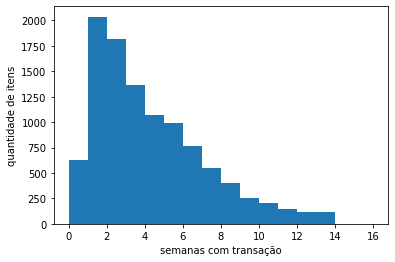

In [357]:
plt.hist(counts, bins = range(17))
plt.ylabel('quantidade de itens')
plt.xlabel('semanas com transação')
plt.show()

In [359]:
data.head()

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2firstvalueLeak,total_new
0,-13,1,0.0,0,1,4.38,1,1,1,8.84,0.0,0.0,0.0,0.0,1431.0
1,-12,1,2.0,0,1,4.38,1,1,1,8.84,0.0,0.0,0.0,1.0,729.0
2,-11,1,313.0,0,1,4.38,1,1,1,8.84,2.0,1.0,0.0,0.0,371.0
3,-10,1,35.0,0,1,4.38,1,1,1,8.84,313.0,157.5,0.0,0.0,533.0
4,-9,1,3.0,0,1,4.38,1,1,1,8.84,35.0,174.0,87.5,0.0,785.0


##  - Split Data

In [675]:
filtered_data = data

In [676]:
len(data), len(filtered_data)

(136019, 136019)

In [677]:
sub_week = -1
train = filtered_data.query('-13 <= weekpair <= (@sub_week - 2)').reset_index(drop = True)
full_train = filtered_data.query('-13 <= weekpair <= (@sub_week - 1)').reset_index(drop = True)
val = filtered_data.query('weekpair == (@sub_week - 1)').reset_index(drop = True)
sub = filtered_data.query('weekpair == (@sub_week)').reset_index(drop = True)

In [678]:
len(train), len(val), len(sub)

(115093, 10463, 10463)

In [679]:
weights = infos.set_index('itemID')['simulationPrice'].to_dict()

In [680]:
train.columns

Index(['weekpair', 'itemID', 'order', 'brand', 'manufacturer',
       'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice', 'item_1', 'item_2', 'item_4',
       'dist2firstvalueLeak', 'leak_cat3', 'total_new'],
      dtype='object')

In [681]:
y_train = train.pop('order').values
y_full_train = full_train.pop('order').values
y_val = val.pop('order').values
y_sub = sub.pop('order').values

X_train = train.values
X_full_train = full_train.values
X_val = val.values
X_sub = sub.values

w_train = train['itemID'].map(weights)
w_full_train = full_train['itemID'].map(weights)
w_val = val['itemID'].map(weights)
w_sub = sub['itemID'].map(weights)

<hr>

## - Min Expected Error

In [682]:
def evaluate(prediction, target, simulationPrice):
    return np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)

In [683]:
from sklearn.metrics import mean_squared_error as mse

<hr>

## - XGBoost

In [684]:
import xgboost as xgb

In [685]:
xgb.__version__

'1.1.0'

In [686]:
# custom objective

def gradient(prediction, dtrain):
    y = dtrain.get_label()
    return -2 * (prediction - np.maximum(prediction - y, 0) * 1.6) * (1 - (prediction > y) * 1.6)

def hessian(prediction, dtrain):
    y = dtrain.get_label()
    return -2 * (1 - (prediction > y) * 1.6) ** 2

def objective(prediction, dtrain):
    w = dtrain.get_weight()
    grad = gradient(prediction, dtrain) * w
    hess = hessian(prediction, dtrain) * w
    return grad, hess

In [687]:
# custom feval

def feval(prediction, dtrain):
    prediction = prediction.astype(int)
    target = dtrain.get_label()
    simulationPrice = dtrain.get_weight()
    return 'feval', np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)

In [ ]:
missing = 0
dtrain = xgb.DMatrix(X_train, y_train, w_train, missing = missing)
dfulltrain = xgb.DMatrix(X_full_train, y_full_train, w_full_train, missing = missing)
dval = xgb.DMatrix(X_val, y_val, w_val, missing = missing)
dsub = xgb.DMatrix(X_sub, y_sub, w_sub, missing = missing)

# specify parameters via map
param = {
    'max_depth':10,
    'eta':0.005,
    'objective':'reg:squarederror',
    'disable_default_eval_metric': 1,
    "min_child_weight" : 3,

}

num_round = 400
bst = xgb.train(param, dtrain,
                num_round,
                early_stopping_rounds = 10,
                evals = [(dtrain, 'train'), (dval, 'val')],
                feval = feval,
                maximize = True,
                )

In [714]:
prediction = bst.predict(dsub, ntree_limit=bst.best_ntree_limit).astype(int)
evaluate(prediction, y_sub, w_sub)

601267.9679999999

In [715]:
# retrain!

In [716]:
bst_sub = xgb.train(param, dfulltrain,
    num_boost_round = bst.best_ntree_limit,
    feval = feval, maximize = True,
    evals = [(dfulltrain, 'ftrain')],
    verbose_eval = False,
)
bst_sub.best_ntree_limit

108

In [717]:
prediction = bst_sub.predict(dsub, ntree_limit=bst_sub.best_ntree_limit).astype(int)
evaluate(prediction, y_sub, w_sub)

670062.6059999999

In [410]:
# some other things below

In [413]:
submission = items[['itemID']].copy()
submission['demandPrediction'] = bst.predict(dsub, ntree_limit=bst.best_ntree_limit).astype(int)
submission.to_csv('../../submissions/sub_inclass_03.csv', sep = '|', index=False)
submission.head()

<hr>

## - LGBM

In [643]:
def feval_lgbm(prediction, dtrain):
    prediction = prediction.astype(int)
    target = dtrain.get_label()
    simulationPrice = dtrain.get_weight()
    return 'feval', np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice), True

In [799]:
data.columns

Index(['weekpair', 'itemID', 'order', 'brand', 'manufacturer',
       'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice', 'item_1', 'item_2', 'item_4',
       'dist2firstvalueLeak', 'leak_cat3', 'total_new'],
      dtype='object')

In [796]:
list(data.columns).index("dist2firstvalueLeak")

13

In [802]:
import lightgbm as lgb

params = {
          "objective" : 'regression_l1',
          "learning_rate" : 0.05,
          'verbosity': 2,
#           'max_depth': 6,
#           'num_leaves': 15,
          "min_data_in_leaf":1500
         }
# https://lightgbm.readthedocs.io/en/latest/Parameters.html


ds_params = {
#     'categorical_feature' : [3, 4, 5, 7, list(data.columns).index("dist2firstvalueLeak"),],
}
lgbtrain = lgb.Dataset(X_train, label = y_train, weight=w_train, **ds_params)
lgbfulltrain = lgb.Dataset(X_full_train, label = y_full_train, weight=w_full_train, **ds_params)
lgbvalid = lgb.Dataset(X_val, label = y_val, weight=w_val, **ds_params)
lgbsubmis = lgb.Dataset(X_sub, label = y_sub, weight=w_sub, **ds_params)

num_round = 1000
lgb_model = lgb.train(params,
                  lgbtrain,
                  num_round,
                  valid_sets = [lgbtrain, lgbvalid],
                  valid_names = ['train', 'val'],
                  verbose_eval=5,
                  early_stopping_rounds=5,
                  feval = feval_lgbm,
#                   fobj = objective,
                 )

Training until validation scores don't improve for 5 rounds
[5]	train's l2: 1464.75	train's feval: -1.32057e+07	val's l2: 1858.36	val's feval: -1.01674e+06
[10]	train's l2: 1394.43	train's feval: -8.75271e+06	val's l2: 1778.31	val's feval: -708249
[15]	train's l2: 1348.92	train's feval: -6.43177e+06	val's l2: 1730.32	val's feval: -384746
[20]	train's l2: 1317.45	train's feval: -2.51634e+06	val's l2: 1699.24	val's feval: -260048
[25]	train's l2: 1296.63	train's feval: -1.63339e+06	val's l2: 1680.72	val's feval: -90904.3
[30]	train's l2: 1279.16	train's feval: -317393	val's l2: 1667.82	val's feval: -52188.8
[35]	train's l2: 1265.51	train's feval: 1.96098e+06	val's l2: 1658.66	val's feval: 54488.2
[40]	train's l2: 1256.37	train's feval: 2.95818e+06	val's l2: 1653.26	val's feval: 155709
[45]	train's l2: 1248.77	train's feval: 3.32183e+06	val's l2: 1650.56	val's feval: 201968
[50]	train's l2: 1242.02	train's feval: 3.28291e+06	val's l2: 1646.69	val's feval: 169352
Early stopping, best itera

In [803]:
prediction = lgb_model.predict(X_sub, num_iteration=lgb_model.best_iteration).astype(int)
evaluate(prediction, y_sub, w_sub)

324378.17599999957

In [646]:
# retrain!

In [647]:
lgb_model_sub = lgb.train(params,
                  lgbfulltrain,
                  lgb_model.best_iteration,
                  valid_sets = [lgbfulltrain],
                  valid_names = ['train'],
                  verbose_eval=5,
                  early_stopping_rounds=None,
                 feval = feval_lgbm,
#                   fobj = objective,
                 )

[5]	train's l1: 4.73405	train's feval: 1.18954e+06
[10]	train's l1: 4.66981	train's feval: 2.33127e+06
[15]	train's l1: 4.62713	train's feval: 3.06989e+06
[20]	train's l1: 4.58673	train's feval: 3.73909e+06
[25]	train's l1: 4.56596	train's feval: 4.30633e+06
[30]	train's l1: 4.54644	train's feval: 4.59851e+06


In [648]:
prediction = lgb_model_sub.predict(X_sub, num_iteration=80).astype(int)
evaluate(prediction, y_sub, w_sub)

377472.03800000006

<hr>

## - CatBoost

In [720]:
from catboost import CatBoost, CatBoostRegressor, Pool

In [740]:
smthing =0

In [763]:
class feval_cat(object):
    def get_final_error(self, error, weight):
        # return error / (weight + 1e-38)
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, simulationPrice):
#         global smthing
#         smthing = [approxes, target, simulationPrice]
        prediction = np.array(approxes[0]).astype(int)
        target = np.array(target).astype(int)
        simulationPrice = np.array(simulationPrice)
        score = np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)
#         print('score', score)
#         print(approxes, type(target), type(simulationPrice))
        return score, 0

In [781]:
ds_params = {
#     'cat_features' : [8, 9, 10],
}
train_pool = Pool(X_train, label = y_train, weight = w_train, **ds_params)
trainfull_pool = Pool(X_full_train, label = y_full_train, weight = w_full_train, **ds_params)
val_pool = Pool(X_val, label = y_val, weight = w_sub, **ds_params)
sub_pool = Pool(X_sub, label = y_sub, weight = w_sub, **ds_params)


model = CatBoostRegressor(
#     iterations = 2,
    depth=7, 
    learning_rate=0.1, 
    loss_function='MAE',
    early_stopping_rounds=5,
    eval_metric = feval_cat(),
    thread_count=-1,
)

model.fit(
    train_pool,
    eval_set=[train_pool, val_pool],
#     logging_level='Verbose',  # you can uncomment this for text output

);


0:	learn: 2011754.9758495	test: 2011754.9758495	test1: 95470.4920506	best: 95470.4920506 (0)	total: 141ms	remaining: 2m 20s
1:	learn: 3521368.2256168	test: 3521368.2256168	test1: 283205.4483849	best: 283205.4483849 (1)	total: 276ms	remaining: 2m 17s
2:	learn: 3521368.2256168	test: 3521368.2256168	test1: 283205.4483849	best: 283205.4483849 (1)	total: 411ms	remaining: 2m 16s
3:	learn: 3546543.9535929	test: 3546543.9535929	test1: 287535.7763555	best: 287535.7763555 (3)	total: 542ms	remaining: 2m 15s
4:	learn: 3593008.8236620	test: 3593008.8236620	test1: 293544.6103613	best: 293544.6103613 (4)	total: 674ms	remaining: 2m 14s
5:	learn: 3633506.9895224	test: 3633506.9895224	test1: 298714.9183608	best: 298714.9183608 (5)	total: 800ms	remaining: 2m 12s
6:	learn: 3665921.2775641	test: 3665921.2775641	test1: 304708.5463808	best: 304708.5463808 (6)	total: 928ms	remaining: 2m 11s
7:	learn: 3678293.0935996	test: 3678293.0935996	test1: 309004.2863847	best: 309004.2863847 (7)	total: 1.06s	remaining: 2

In [782]:
prediction = model.predict(X_sub, ntree_end = model.best_iteration_).astype(int)
evaluate(prediction, y_sub, w_sub)

646147.878

In [783]:
# retrain!

In [784]:
model.best_iteration_

19

In [792]:
{**model.get_params(), "iterations" : model.best_iteration_}

{'learning_rate': 0.1,
 'depth': 7,
 'loss_function': 'MAE',
 'eval_metric': <__main__.feval_cat at 0x7f5b9540a650>,
 'early_stopping_rounds': 5,
 'iterations': 19}

In [793]:
cat_sub = CatBoostRegressor(**{**model.get_params(), "iterations" : model.best_iteration_})
cat_sub.fit(
    trainfull_pool,
    eval_set=[trainfull_pool],
#     logging_level='Verbose',  # you can uncomment this for text output

);

0:	learn: 2114078.5579041	test: 2114078.5579041	best: 2114078.5579041 (0)	total: 148ms	remaining: 2.66s
1:	learn: 3796402.2199379	test: 3796402.2199379	best: 3796402.2199379 (1)	total: 294ms	remaining: 2.5s
2:	learn: 3796402.2199379	test: 3796402.2199379	best: 3796402.2199379 (1)	total: 442ms	remaining: 2.36s
3:	learn: 3824880.7719073	test: 3824880.7719073	best: 3824880.7719073 (3)	total: 583ms	remaining: 2.19s
4:	learn: 3873897.6879564	test: 3873897.6879564	best: 3873897.6879564 (4)	total: 726ms	remaining: 2.03s
5:	learn: 3914757.0118816	test: 3914757.0118816	best: 3914757.0118816 (5)	total: 872ms	remaining: 1.89s
6:	learn: 3951498.1998777	test: 3951498.1998777	best: 3951498.1998777 (6)	total: 1.02s	remaining: 1.74s
7:	learn: 3972186.7619421	test: 3972186.7619421	best: 3972186.7619421 (7)	total: 1.16s	remaining: 1.59s
8:	learn: 4775951.7779054	test: 4775951.7779054	best: 4775951.7779054 (8)	total: 1.3s	remaining: 1.45s
9:	learn: 5573463.0077655	test: 5573463.0077655	best: 5573463.0077

In [794]:
prediction = cat_sub.predict(X_sub, ntree_end = cat_sub.best_iteration_).astype(int)
evaluate(prediction, y_sub, w_sub)

620681.426

<hr>

## - Ensemble

In [775]:
cat_w = 1
lgb_w = 1
xgb_w = 1
ensemble = model.predict(X_sub, ntree_end = model.best_iteration_) * cat_w
ensemble += lgb_model.predict(X_sub, num_iteration=lgb_model.best_iteration) * lgb_w
ensemble += bst.predict(dsub, ntree_limit=bst.best_ntree_limit) * xgb_w
ensemble = ensemble / (cat_w + lgb_w + xgb_w)
evaluate(ensemble.astype(int), y_sub, w_sub)

681241.5599999999

<hr>

## - Linear Regression

In [776]:
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import 

In [777]:
lr = LinearRegression()

In [778]:
lr.fit(X_train, y_train, w_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [780]:
print('train', evaluate(lr.predict(X_train), y_train, w_train))
print('test', evaluate(lr.predict(X_val), y_val, w_val))
print('sub', evaluate(lr.predict(X_sub), y_sub, w_sub))

train -25798195.590995364
test -2082818.3608716822
sub -2279245.550001612


<hr>

In [ ]:
# fazer feature que pega o percentil de quando o item deu de dinheiro dentro de uma categoria
# fazer features que pega dist de atual até o pico mais alto
# dist do maior pico pro segundo
# min(dist(terceiro, primeiro), dist(terceiro, segundo))